# LINEST (как в Excel), но для **любой** таблицы — задачник для студентов 🧩

Вы повторите Excel `ЛИНЕЙН/LINEST` на **любом датасете** с помощью `scikit-learn` и `numpy`.
Это **не автозапускной** ноутбук: внутри есть **TODO**, подсказки и проверки.

Что нужно:
- CSV/таблица с **числовыми признаками** `x1..xk` (или любыми именами колонок) и **целевой** `y`.
- `y` может быть **непрерывной** (обычная регрессия) или **целочисленной** (классы 1..C). Для классов мы сделаем трюк: регрессия + округление.

Вы научитесь:
1) Подготовке `X` и `y` для произвольного набора колонок.
2) Обучению `LinearRegression` (аналог Excel LINEST) и получению прогноза `ŷ`.
3) Расчёту метрик `R²`, `SE_y`, `F`, `df`, `SSreg`, `SSresid`.
4) Оценке **SE коэффициентов** и сборке **пятирядного блока** как в Excel.
5) (Опционально) переводу `ŷ` в классы округлением и расчёту **accuracy**.

⚠️ Если ваш `y` — настоящий класс, в реальных задачах лучше использовать **логистическую регрессию**; здесь — учебный аналог LINEST.

## Шаг 0. Импорты и настройки
Запустите. Ничего менять не нужно.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
plt.rcParams['figure.figsize'] = (6, 4)
np.set_printoptions(suppress=True, precision=6)
pd.set_option('display.precision', 6)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

## Шаг 1. Укажите путь к **вашему** CSV и нужные колонки
Заполните переменные ниже: `CSV_PATH`, `FEATURE_COLS` (список признаков), `TARGET_COL` (целевой).

**TODO:** задайте значения и удалите `raise NotImplementedError`. Если у вас уже `x1..x4,y`, просто укажите эти имена.

In [2]:
# === НАСТРОЙТЕ ЭТИ ПЕРЕМЕННЫЕ ПОД СВОЙ ФАЙЛ ===
CSV_PATH = '/content/StressLevelDataset.csv'
FEATURE_COLS = ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression',
       'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem',
       'noise_level', 'living_conditions', 'safety', 'basic_needs',
       'academic_performance', 'study_load', 'teacher_student_relationship',
       'future_career_concerns', 'social_support', 'peer_pressure',
       'extracurricular_activities', 'bullying']
TARGET_COL = 'stress_level'

In [3]:
df = pd.read_csv('/content/StressLevelDataset.csv')
df.columns

Index(['anxiety_level', 'self_esteem', 'mental_health_history', 'depression',
       'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem',
       'noise_level', 'living_conditions', 'safety', 'basic_needs',
       'academic_performance', 'study_load', 'teacher_student_relationship',
       'future_career_concerns', 'social_support', 'peer_pressure',
       'extracurricular_activities', 'bullying', 'stress_level'],
      dtype='object')

In [5]:
df.basic_needs.unique() #проверка уникальных значений одного из фактора (в том числе и для определния типа переменной)

array([2, 3, 1, 4, 5, 0])

In [ ]:
df.isna().sum() #нет нулевых значений

,0
anxiety_level,0
self_esteem,0
mental_health_history,0
depression,0
headache,0
blood_pressure,0
sleep_quality,0
breathing_problem,0
noise_level,0
living_conditions,0


Порядковые признаки (с естественным порядком, например от 0 до 5) при построении линейной модели можно представлять как количественные переменные. Предварительно мы предположили приблизительную равномерность интервалов.

Часть факторов являются порядковыми шкалами (например, 1–5), однако в рамках данной работы они интерпретированы как количественные переменные, что допустимо при построении линейных моделей

## Шаг 2. Загрузка данных и базовая проверка
Прочитайте CSV в `df`, убедитесь, что выбранные колонки существуют, и что `y` — числовой столбец.

In [6]:
df = pd.read_csv(CSV_PATH)
assert all(col in df.columns for col in FEATURE_COLS), 'Не найдены все признаки в таблице'
assert TARGET_COL in df.columns, 'Не найден столбец TARGET_COL'
# Попробуем привести y к числу (если классы записаны строками, преобразуйте их заранее)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
assert df[TARGET_COL].notna().all(), 'В y должны быть числа (при необходимости предварительно закодируйте классы)'
df.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


## Шаг 3. Собираем матрицы `X`, `y` и обучаем **LinearRegression** (= LINEST)
Получите `ŷ` и остатки `resid = y - ŷ`.

**TODO:** заполните и удалите `raise NotImplementedError`.

In [7]:
# TODO: сформируйте X, y, обучите модель и получите y_hat и resid
# Подсказки:
X = df[FEATURE_COLS].to_numpy()
y = df[TARGET_COL].to_numpy().astype(float)
model = LinearRegression(fit_intercept=True).fit(X, y)
y_hat = model.predict(X)
resid = y - y_hat

### Самопроверка A

In [8]:
n, k = X.shape
assert y.shape == (n,), 'y должен быть вектором длины n'
assert k >= 1, 'Нужно минимум 1 признак'
print('OK: n=%d, k=%d' % (n, k))

OK: n=1100, k=20


**Текст, выделенный полужирным шрифтом**## Шаг 4. Базовые суммы квадратов и метрики LINEST
Посчитайте:
- `SStot = Σ (y - ȳ)²`
- `SSresid = Σ (y - ŷ)²`
- `SSreg = SStot - SSresid`
- `R² = 1 - SSresid/SStot`
- `df = n - k - 1`
- `SE_y = √(SSresid/df)`
- `F = (SSreg/k)/(SSresid/df)`

**TODO:** заполните формулы.

In [9]:
# TODO: заполните вычисления ниже

y_bar = y.mean()
n = y.shape[0]                 # число наблюдений
k = X.shape[1]                 # число признаков (без интерсепта)

SStot = np.sum((y - y_bar)**2)
SSresid = np.sum((y - y_hat)**2)
SSreg = SStot - SSresid
R2 = 1 - SSresid / SStot if SStot != 0 else np.nan
df_resid = n - k - 1
SE_y = np.sqrt(SSresid / df_resid)
F = (SSreg / k) / (SSresid / df_resid) if (k > 0 and SSresid > 0) else np.inf

In [10]:
MSE = mean_squared_error(y, y_hat) #среднеквадратичная ошибка
R2_adj = 1 - (1-R2)*(n-1)/(n-k-1) #Показатель системного эффекта факторов
# Мера мультиколлинеарности
X_const = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = ["const"] + FEATURE_COLS
vif["VIF"] = [variance_inflation_factor(X_const, i) for i in range(X_const.shape[1])]
# вывод
print(f"Коэффициент детерминации (R^2): {R2:.4f}")
print(f"Среднеквадратическая ошибка (MSE): {MSE:.4f}")
print(f"Системный эффект факторов (Adjusted R^2): {R2_adj:.4f}")
print("\nМера мультиколлинеарности (VIF):")
print(vif)

Коэффициент детерминации (R^2): 0.7964
Среднеквадратическая ошибка (MSE): 0.1373
Системный эффект факторов (Adjusted R^2): 0.7926

Мера мультиколлинеарности (VIF):
                         feature         VIF
0                          const  139.636943
1                  anxiety_level    3.226378
2                    self_esteem    3.208365
3          mental_health_history    2.218410
4                     depression    3.090505
5                       headache    2.534846
6                 blood_pressure    3.686664
7                  sleep_quality    3.089081
8              breathing_problem    1.784443
9                    noise_level    1.990095
10             living_conditions    1.797776
11                        safety    2.790136
12                   basic_needs    2.679847
13          academic_performance    2.706926
14                    study_load    1.900661
15  teacher_student_relationship    3.198274
16        future_career_concerns    3.416580
17                social_s

VIF 2–5  умеренная коллинеарность (обычно допустимо).
Выделяется social_support - при последующей проверке на матрице корреляций убирается

### Самопроверка B

In [11]:
assert df_resid == n - k - 1, 'df должно быть n - k - 1'
assert SStot >= 0 and SSresid >= 0 and SSreg >= 0, 'Суммы квадратов не могут быть отрицательными'
assert 0 <= R2 <= 1 or np.isclose(R2, 1.0) or np.isclose(R2, 0.0), 'R^2 должен быть в [0,1] на тренировочных данных'
print('OK')

OK


## Шаг 5. **SE** коэффициентов (2-я строка LINEST)
Соберите дизайн-матрицу `X1 = [X, 1]` и используйте формулу:
\[ \mathrm{Var}(\hat{\beta}) = \sigma^2 (X_1^\top X_1)^{-1},\quad \sigma^2 = SS_{resid}/df. \]
Иногда матрица может быть близка к вырожденной — используйте `np.linalg.pinv` как запасной вариант.

**TODO:** заполните.

In [12]:
# TODO: посчитайте se_beta для [m1..mk, b0]
X1 = np.column_stack([X, np.ones(n)])
XtX = X1.T @ X1
try:
    XtX_inv = np.linalg.inv(XtX)
except np.linalg.LinAlgError:
    XtX_inv = np.linalg.pinv(XtX)  # запасной вариант
sigma2 = SSresid / df_resid
se_beta = np.sqrt(np.diag(sigma2 * XtX_inv))
se_beta

array([0.003314, 0.00226 , 0.033611, 0.002568, 0.012751, 0.025999,
       0.012812, 0.010764, 0.011989, 0.013522, 0.013408, 0.012887,
       0.013128, 0.011826, 0.014579, 0.013641, 0.02582 , 0.012786,
       0.01263 , 0.013162, 0.133315])

## Шаг 6. Собираем **пятирядный блок** как в Excel
- 1-я строка: коэффициенты `{m_k, …, m_1, b0}` (обратите внимание на **обратный порядок признаков**, как в LINEST)
- 2-я: SE в том же порядке
- 3-я: `{R², SE_y, NA, NA, NA}`
- 4-я: `{F, df, NA, NA, NA}`
- 5-я: `{SSreg, SSresid, NA, NA, NA}`

**TODO:** заполните.

In [13]:
coefs = getattr(model, 'coef_', None)
intercept = getattr(model, 'intercept_', None)
linest_like = pd.DataFrame(index=[1,2,3,4,5], columns=[f'c{i+1}' for i in range(k+1)])

# TODO: заполните строки 1 и 2 с учётом обратного порядка коэффициентов
rev_coefs = list(coefs[::-1]) + [intercept]
rev_se = list(se_beta[:k][::-1]) + [se_beta[-1]]
linest_like.loc[1, :] = rev_coefs
linest_like.loc[2, :] = rev_se

# Строки 3–5: только первые 2 столбца, остальные — NaN (как #Н/Д в Excel)
linest_like.loc[3, :] = [R2, SE_y] + [np.nan]* (k-1)
linest_like.loc[4, :] = [F, df_resid] + [np.nan]* (k-1)
linest_like.loc[5, :] = [SSreg, SSresid] + [np.nan]* (k-1)
linest_like

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21
1,0.056926,0.043473,0.032897,-0.044595,0.013881,0.040157,0.042561,-0.056223,-0.051162,-0.046428,...,0.063398,0.009784,-0.05159,-0.044644,0.05908,0.005991,-0.000569,-0.014092,0.002949,0.942796
2,0.013162,0.01263,0.012786,0.02582,0.013641,0.014579,0.011826,0.013128,0.012887,0.013408,...,0.011989,0.010764,0.012812,0.025999,0.012751,0.002568,0.033611,0.00226,0.003314,0.133315
3,0.796401,0.374175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,211.031607,1079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,590.917931,151.067524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Шаг 7. (Опционально) Если `y` — **целые классы**, округлите `ŷ` и посчитайте **accuracy**
Установите `TREAT_AS_CLASSES = True`, если хотите режим «классы через округление». Если у вас обычная регрессия — оставьте `False`.

In [14]:
TREAT_AS_CLASSES = True  # поменяйте на True, если y — целые классы
if TREAT_AS_CLASSES:
    y_min, y_max = int(np.nanmin(y)), int(np.nanmax(y))
    y_pred_class = np.clip(np.rint(y_hat), y_min, y_max).astype(int)

    # TODO: Исправьте строку выше: должно быть округление **ŷ**, а не y
    # Подсказка: используйте y_hat вместо y
    # y_pred_class = np.clip(np.rint( ... ), y_min, y_max).astype(int)
    acc = accuracy_score(y.astype(int), y_pred_class)
    print('Accuracy:', round(acc, 4))

Accuracy: 0.8755


## Шаг 8. (Опционально) Матрица ошибок и два графика

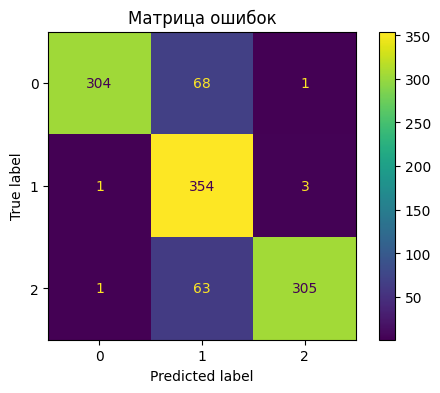

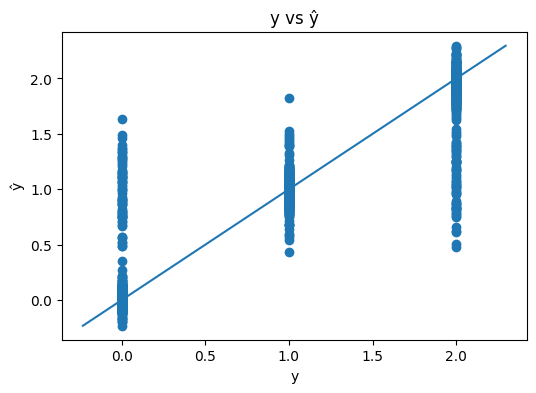

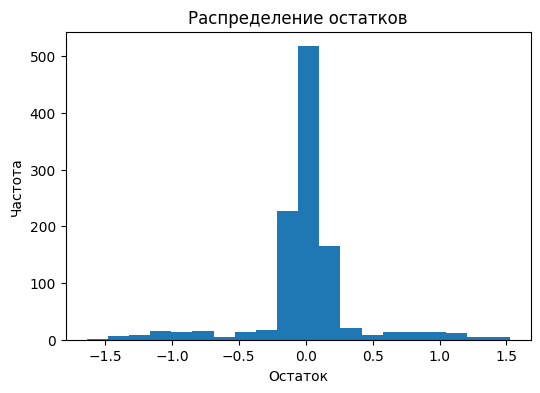

In [15]:
if TREAT_AS_CLASSES:
    cm = confusion_matrix(y.astype(int), y_pred_class, labels=sorted(np.unique(y_pred_class)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y_pred_class)))
    disp.plot(); plt.title('Матрица ошибок'); plt.show()

plt.figure(); plt.scatter(y, y_hat); mn, mx = np.nanmin([y.min(), y_hat.min()]), np.nanmax([y.max(), y_hat.max()]); plt.plot([mn,mx],[mn,mx]); plt.xlabel('y'); plt.ylabel('ŷ'); plt.title('y vs ŷ'); plt.show()
plt.figure(); plt.hist(y - y_hat, bins=20); plt.xlabel('Остаток'); plt.ylabel('Частота'); plt.title('Распределение остатков'); plt.show()

In [16]:
# корреляционная матрица
corr = df.corr(method='pearson')
display(corr.round(3))

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
anxiety_level,1.000,-0.673,0.634,0.694,0.633,0.331,-0.710,0.562,0.609,-0.568,...,-0.637,-0.650,0.586,-0.663,0.717,-0.570,0.643,0.641,0.710,0.737
self_esteem,-0.673,1.000,-0.604,-0.700,-0.626,-0.515,0.663,-0.511,-0.571,0.551,...,0.631,0.639,-0.575,0.653,-0.713,0.679,-0.607,-0.641,-0.641,-0.756
mental_health_history,0.634,-0.604,1.000,0.616,0.605,0.296,-0.614,0.464,0.515,-0.509,...,-0.601,-0.586,0.532,-0.588,0.626,-0.483,0.581,0.555,0.624,0.649
depression,0.694,-0.700,0.616,1.000,0.658,0.436,-0.693,0.523,0.566,-0.530,...,-0.609,-0.633,0.602,-0.674,0.707,-0.618,0.636,0.649,0.666,0.734
headache,0.633,-0.626,0.605,0.658,1.000,0.362,-0.639,0.462,0.544,-0.533,...,-0.623,-0.622,0.543,-0.626,0.679,-0.573,0.623,0.583,0.610,0.713
blood_pressure,0.331,-0.515,0.296,0.436,0.362,1.000,-0.300,0.162,0.353,-0.275,...,-0.281,-0.263,0.349,-0.352,0.434,-0.753,0.401,0.426,0.370,0.394
sleep_quality,-0.710,0.663,-0.614,-0.693,-0.639,-0.300,1.000,-0.542,-0.577,0.535,...,0.621,0.671,-0.552,0.678,-0.682,0.555,-0.649,-0.623,-0.699,-0.749
breathing_problem,0.562,-0.511,0.464,0.523,0.462,0.162,-0.542,1.000,0.459,-0.449,...,-0.508,-0.507,0.429,-0.499,0.545,-0.365,0.493,0.517,0.576,0.574
noise_level,0.609,-0.571,0.515,0.566,0.544,0.353,-0.577,0.459,1.000,-0.452,...,-0.572,-0.514,0.494,-0.539,0.575,-0.492,0.584,0.564,0.585,0.663
living_conditions,-0.568,0.551,-0.509,-0.530,-0.533,-0.275,0.535,-0.449,-0.452,1.000,...,0.503,0.507,-0.438,0.549,-0.565,0.467,-0.502,-0.516,-0.551,-0.582


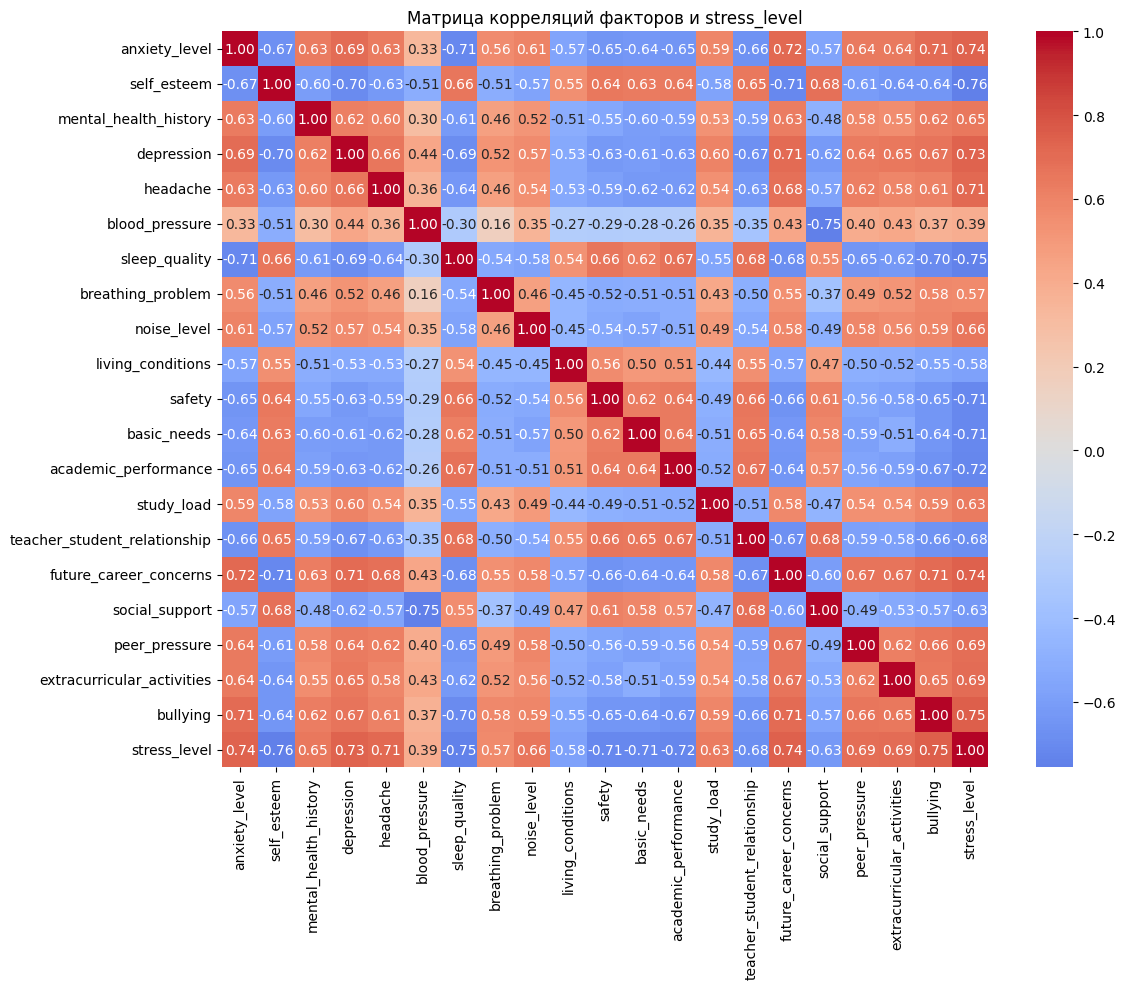

In [17]:
# тепловая карта
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций факторов и stress_level")
plt.tight_layout()
plt.show()

Порог «высокой корреляции» было принято взять как 0.65. по соображениям смысла исключаем депресию и уровень тревоги, предполагая, что они все входят в **историю ментального здоровья**.

Далее видим высокую коллеряцию между признаками self_esteem и future_career_concerns. у self_esteem выше корреляция с целевой переменной, что плюс, так же почти по всем другим признака кореляция у future_career_concerns с другими признаками незначительно, но выше, чем у self_esteem, что не в пользу future_career_concerns. поэтому предпочтителен признак **self_esteem**.

self_esteem vs social support. у social support корреляция с целевой переменной ниже. но social support при этом меньше коррелирует с другими признаками.

Для учебной регрессии, где важна именно объясняющая способность, оставим self_esteem. Альтернативой был social_support, но он уступает по силе связи с целевой переменной, поэтому выбран self_esteem несмотря на более высокую корреляцию с другими факторами.

По тому же принципу отсекаем teachers_stedents_relationships,
sleep_quality тоже минус: ниже корреляция с целевой, и чуть выше с другими признаками.

**blood_pressure** оставим: невыская корреляция с другими признаками.
**headache** оставляем, сильно коррелирует с целевой и с другими признаками корреляция не превышает 0.65, не считая уже исключенных.

**breathing_problem** и **noise_level**, **living_conditions** по аналогии с blood_pressure оставим.

**safety** vs bullying,у bullying выше корреляция с целевой, но выше корреляция с дургими принаками, поскольку различия в корреляции с целевой не высокое - оставим safety + как более обобщенное понятие, включающее bullying.




У **basic_needs**, **academic_perfomance**, **study_load**, **peer_pressure**, **extracurricular_activities** нет корреляции с оставшимися признаками выше порогового значения - признаки оставляем.


*Итого из признаков остаются:* mental_health_history, self_esteem, blood_pressure, headache, breathing_problem, noise_level, living_conditions, safety, basic_needs, academic_perfomance, study_load, peer_pressure, extracurricular_activities (13)

*Убираются:* anxiety_level, depression, future_career_concerns, social support, teachers_stedents_relationships, sleep_quality, bullying (7)

In [19]:
df_new = df[[
    'mental_health_history', 'self_esteem', 'blood_pressure', 'headache',
    'breathing_problem', 'noise_level', 'living_conditions', 'safety',
    'basic_needs', 'academic_performance', 'study_load', 'peer_pressure',
    'extracurricular_activities', 'stress_level'
]]

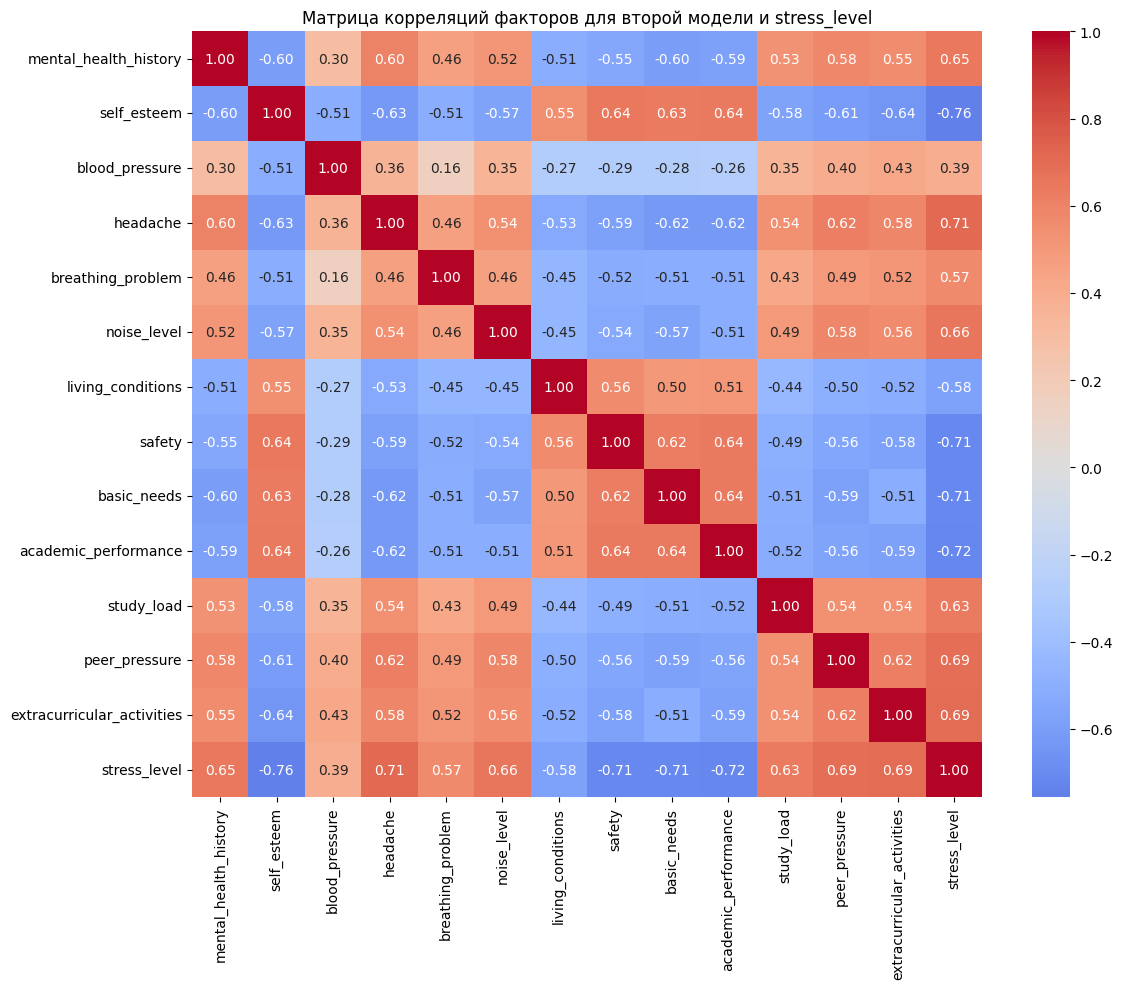

In [20]:
corr_new = df_new.corr(method='pearson')
plt.figure(figsize=(12,10))
sns.heatmap(corr_new, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций факторов для второй модели и stress_level")
plt.tight_layout()
plt.show()

In [ ]:
# выбранные признаки
selected_features = [
    'mental_health_history', 'self_esteem', 'blood_pressure', 'headache',
    'breathing_problem', 'noise_level', 'living_conditions', 'safety',
    'basic_needs', 'academic_performance', 'study_load', 'peer_pressure',
    'extracurricular_activities'
]

In [ ]:
# формируем X, y
X_new = df[selected_features].to_numpy()
y = df[TARGET_COL].to_numpy().astype(float)

In [ ]:
# обучаем модель
model_new = LinearRegression(fit_intercept=True).fit(X_new, y)

In [ ]:
# предсказания и остатки
y_hat_new = model_new.predict(X_new)
resid_new = y - y_hat_new

R2_new = r2_score(y, y_hat_new)

n = y.shape[0]                 # число наблюдений
p = X_new.shape[1]                 # число признаков


In [ ]:
MSE_new = mean_squared_error(y, y_hat_new) #среднеквадратичная ошибка
R2_adj_new = 1 - (1-R2_new)*(n-1)/(n-p-1) #Показатель системного эффекта факторов
# Мера мультиколлинеарности
X_new_const = sm.add_constant(X_new)
vif = pd.DataFrame()
vif["feature"] = ["const"] + selected_features
vif["VIF"] = [variance_inflation_factor(X_new_const, i) for i in range(X_new_const.shape[1])]
# --- вывод ---
print(f"Коэффициент детерминации (R^2): {R2_new:.4f}")
print(f"Среднеквадратическая ошибка (MSE): {MSE_new:.4f}")
print(f"Системный эффект факторов (Adjusted R^2): {R2_adj_new:.4f}")
print("\nМера мультиколлинеарности (VIF):")
print(vif)

Коэффициент детерминации (R^2): 0.7844
Среднеквадратическая ошибка (MSE): 0.1454
Системный эффект факторов (Adjusted R^2): 0.7819

Мера мультиколлинеарности (VIF):
                       feature        VIF
0                        const  93.552144
1        mental_health_history   2.130982
2                  self_esteem   3.023219
3               blood_pressure   1.519081
4                     headache   2.395692
5            breathing_problem   1.707849
6                  noise_level   1.944536
7            living_conditions   1.763267
8                       safety   2.386688
9                  basic_needs   2.463827
10        academic_performance   2.445633
11                  study_load   1.820604
12               peer_pressure   2.333440
13  extracurricular_activities   2.378872


Модель 1 (все факторы, 20 признаков)
R² = 0.7964
MSE = 0.1373
Adjusted R² = 0.7926
VIF: большинство признаков в пределах нормы, но social_support = 5.7 (выше порога).



Модель 2 (после отбора, 13 признаков)
R² = 0.7844 (чуть ниже)
MSE = 0.1454 (чуть выше, значит средняя ошибка прогноза увеличилась)
Adjusted R² = 0.7819 (разница с моделью 1 несущественная, снижение ~0.01)
VIF: все признаки в пределах нормы (ни одного выше 5) и все менее 3.

Модель 1 объясняет данные чуть лучше (чуть выше R² и ниже MSE).
Но разница очень маленькая: ~1% объяснённой дисперсии.
Модель 2 выигрывает: все признаки имеют VIF < 5, значит, мультиколлинеарность устранена.

Вторая модель объясняет данные почти так же хорошо (разница незначительная), но при этом устраняет проблему мультиколлинеарности, что делает её более устойчивой и интерпретируемой.
Таким образом, исключение части факторов было оправдано: качество модели почти не пострадало, а надёжность анализа улучшилась.

In [ ]:
from scipy.stats import f

# Данные из двух моделей
R2_full = 0.7964
R2_reduced = 0.7844
p_full = 20
p_reduced = 13

# Расчёт F-статистики
num = (R2_full - R2_reduced) / (p_full - p_reduced)
den = (1 - R2_full) / (n - p_full - 1)
F_stat = num / den

# Критическое значение F
alpha = 0.05
df1 = p_full - p_reduced
df2 = n - p_full - 1
F_crit = f.ppf(1 - alpha, df1, df2)

print(f"F-статистика: {F_stat:.4f}")
print(f"Критическое значение F (α=0.05): {F_crit:.4f}")

if F_stat > F_crit:
    print("Исключение факторов статистически ухудшило модель.")
else:
    print("Исключение факторов оправдано — качество модели существенно не ухудшилось.")


F-статистика: 9.0850
Критическое значение F (α=0.05): 2.0181
Исключение факторов статистически ухудшило модель.


По F-критерию исключение факторов приводит к статистически значимому ухудшению качества модели (F=9.085 > Fcrit=2.018, α=0.05).
Однако практическая разница в качестве несущественна (R² снизился всего на 0.012), при этом мультиколлинеарность полностью устранена.
Таким образом, упрощённая модель может считаться предпочтительной с точки зрения интерпретируемости, несмотря на формальный результат критерия Фишера.

In [ ]:
# Шаг 6: Проверка условий Гаусса-Маркова на второй (финальной) модели
# остатки модели показывают, «как она промахивается», и мы смотрим, случайны ли эти промахи или в них есть системная ошибка.
resid_new # Получаем остатки (residuals) из модели

array([ 0.102498,  0.077114, -0.006537, ..., -0.111675, -0.103692,
        0.734198])

In [ ]:
# Runs test (Wald–Wolfowitz) — над/под медианой
# Что проверяем: остатки должны менять знак и значения случайно, без упорядоченных «серий».
# Проверка на случайность остатков (runs test)
def runs_test(resid):
    e = np.asarray(resid)
    median = np.median(e)
    runs = 1
    n1 = 0  # above median
    n2 = 0  # below median
    signs = []
    for val in e:
        if val > median:
            signs.append(1); n1 += 1
        elif val < median:
            signs.append(0); n2 += 1
        else:
            # равные медиане — отбрасываем или приравниваем к одному знаку; здесь по умолчанию отбрасываем
            signs.append(np.nan)
    # удаляем nan
    signs = [s for s in signs if not np.isnan(s)]
    if len(signs) < 2 or n1==0 or n2==0:
        return None
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1]:
            runs += 1
    n = n1 + n2
    # ожидание и дисперсия
    mu = 1 + 2.0*n1*n2 / n
    var = (2.0*n1*n2*(2.0*n1*n2 - n)) / (n**2 * (n-1))
    sigma = np.sqrt(var)
    z = (runs - mu)/sigma
    p_two = 2*(1 - stats.norm.cdf(abs(z)))
    return {'n': n, 'n1': n1, 'n2': n2, 'runs': runs, 'mu': mu, 'var': var, 'z': z, 'p_value_two_sided': p_two}


In [ ]:
runs_test(resid_new)

{'n': 1100,
 'n1': 550,
 'n2': 550,
 'runs': 559,
 'mu': 551.0,
 'var': 274.74977252047313,
 'z': np.float64(0.4826377817256586),
 'p_value_two_sided': np.float64(0.6293529476947388)}

p-value > 0.05, значит, нет оснований отвергать гипотезу о случайности остатков.

In [ ]:
# Jarque-Bera (асимметрия/эксцесс)
# Проверка: нормальность распределения остатков (тест Жарка–Бера)
def jb_test(resid):
    jb_stat, jb_p = stats.jarque_bera(resid)
    skew = stats.skew(resid) #асимметрия
    kurt = stats.kurtosis(resid, fisher=False)  # обычный (not Fisher) -> kurtosis of normal = 3 # при полученном значении распределение очень острое и с тяжёлыми хвостами (в 2–3 раза тяжелее, чем нормальное).
    # можно также вернуть excess = kurt - 3
    excess = kurt - 3
    return {'jb_stat': jb_stat, 'jb_p': jb_p, 'skew': skew, 'kurtosis': kurt, 'excess': excess}

In [ ]:
jb_test(resid_new)

{'jb_stat': np.float64(1472.5151654609929),
 'jb_p': np.float64(0.0),
 'skew': np.float64(-0.37953118506167866),
 'kurtosis': np.float64(8.61706577568046),
 'excess': np.float64(5.6170657756804605)}

p-value = 0, значит, отклоняем H₀ о нормальности.
Отрицательная асимметрия и большой эксцесс - распределение “слева тяжелое”, с пиками и хвостами.

Это не страшно, особенно при большом кол-ве наблюдений. В таких случаях ЦПТ «спасает»: просто тесты могут быть чуть менее точными.

In [ ]:
# Sum of residuals zero (t-test)
# сумма (или среднее) остатков = 0 (t-test)
def resid_mean_ttest(resid):
    t_stat, p = stats.ttest_1samp(resid, popmean=0.0)
    mean = np.mean(resid)
    return {'mean': mean, 't_stat': t_stat, 'p_value_two_sided': p}

In [ ]:
resid_mean_ttest(resid_new)

{'mean': np.float64(-1.1304088978001593e-16),
 't_stat': np.float64(-9.8277183515761e-15),
 'p_value_two_sided': np.float64(0.9999999999999922)}

Остатки в среднем точно 0.
p-value ≈ 1 - гипотеза «среднее = 0» не отвергается.
Проверка пройдена

Остатки в среднем точно 0.
p-value ≈ 1 - гипотеза «среднее = 0» не отвергается.


In [ ]:
# Durbin-Watson (DW)
# независимость остатков (Durbin–Watson)
# Что проверяем: зависит ли остаток сейчас от остатка чуть раньше (например, вчерашняя ошибка влияет на сегодняшнюю).
def durbin_watson_test(resid):
    dw = sm.stats.durbin_watson(resid)
    # интерпретация: dw ~ 2 => нет автокорреляции; dw < 2 => положительная автокорреляция; dw > 2 => отрицательная
    return {'dw_stat': dw}

In [ ]:
durbin_watson_test(resid_new)

{'dw_stat': np.float64(2.008183566257501)}

dw ≈ 2 - нет автокорреляции, остатки независимы. Условие выполняется.

по пунктам Гаусса–Маркова: Случайность остатков (Runs test) - Остатки случайны

Независимость остатков (Durbin–Watson) - независимы

Сумма остатков = 0 (t-test p ≈ 1) - Среднее ≈ 0

Нормальность (Jarque–Bera p = 0) - Отклонение от нормальности (но при большом n не критично)